## Data Processing

### Data Loading

In [169]:
# Cell 1: imports & file paths
import pandas as pd
from datetime import datetime
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
work_pth = '/content/drive/MyDrive/Spring2025/IEOR242B/Project'

In [171]:
base_dir = '/content/drive/MyDrive/Spring2025/IEOR242B/Project'
NOTES_CSV     = '/content/drive/MyDrive/Spring2025/IEOR242B/Project/NOTEEVENTS.csv'    # upload this to Colab
ADMITS_CSV    = '/content/drive/MyDrive/Spring2025/IEOR242B/Project/ADMISSIONS.csv'    # upload this to Colab
OUTPUT_CSV    = '/content/drive/MyDrive/Spring2025/IEOR242B/Project/notes_readmit.csv' # where we’ll save our 3-column table

In [172]:
import pandas as pd
from sklearn.utils import resample

def downsample_negatives(df, label_col='readmitted', seed=42):
    """
    Downsamples negative class to match number of positives (1:1 ratio).
    """
    pos_df = df[df[label_col] == 1]
    neg_df = df[df[label_col] == 0]

    downsampled_neg = resample(neg_df,
                                replace=False,
                                n_samples=len(pos_df),
                                random_state=seed)

    balanced_df = pd.concat([pos_df, downsampled_neg]).sample(frac=1, random_state=seed).reset_index(drop=True)
    return balanced_df


### Data Processing

In [173]:
# Check the actual columns in NOTEEVENTS.csv
# pd.read_csv(NOTES_CSV, nrows=1).columns.tolist()


In [174]:
# Check the actual columns in ADMISSIONS.csv
# pd.read_csv(ADMITS_CSV, nrows=1).columns.tolist()


In [175]:
# # Check all unique note categories
# notes = pd.read_csv(NOTES_CSV, usecols=['CATEGORY'])
# notes['CATEGORY'].value_counts()


In [176]:
# Cell 2: load raw MIMIC CSVs (may take a minute)
notes = pd.read_csv(NOTES_CSV, usecols=['SUBJECT_ID','HADM_ID','CATEGORY','CHARTDATE','CHARTTIME','TEXT'])
admits = pd.read_csv(ADMITS_CSV, usecols=['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME'])

# Keep only discharge summaries
dsum = notes[notes['CATEGORY']=='Discharge summary'].copy()
print(f"Found {len(dsum)} discharge notes")

# Parse datetimes
admits['ADMITTIME']  = pd.to_datetime(admits['ADMITTIME'])
admits['DISCHTIME'] = pd.to_datetime(admits['DISCHTIME'])
dsum['CHARTDATE']   = pd.to_datetime(dsum['CHARTDATE'])  # chart date

# Merge discharge times into notes
df = pd.merge(
    dsum,
    admits[['SUBJECT_ID','HADM_ID','DISCHTIME']],
    on=['SUBJECT_ID','HADM_ID'],
    how='left'
)

# For each patient, find next admission after this discharge
admits_sorted = admits.sort_values(['SUBJECT_ID','ADMITTIME'])
admits_sorted['NEXT_ADMIT'] = admits_sorted.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)

# Merge next-admit time into our df
df = pd.merge(
    df,
    admits_sorted[['SUBJECT_ID','HADM_ID','NEXT_ADMIT']],
    on=['SUBJECT_ID','HADM_ID'],
    how='left'
)

# Compute days to readmit
df['days_to_readmit'] = (df['NEXT_ADMIT'] - df['DISCHTIME']).dt.days

# Label: readmitted within 30 days
df['readmitted'] = (df['days_to_readmit'] <= 30).astype(int).fillna(0)

# Build our final three-column table and drop NA text
output = df[['SUBJECT_ID','TEXT','readmitted']].rename(
    columns={'SUBJECT_ID':'patient_id','TEXT':'text_note'}
).dropna().reset_index(drop=True)

print("Final table rows:", len(output))
output.head(3)


<ipython-input-176-3866a9db1780>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv(NOTES_CSV, usecols=['SUBJECT_ID','HADM_ID','CATEGORY','CHARTDATE','CHARTTIME','TEXT'])


Found 12981 discharge notes
Final table rows: 12981


,patient_id,text_note,readmitted
0,13702,Admission Date: [**2118-6-2**] Discharg...,0
1,13702,Admission Date: [**2119-5-4**] D...,0
2,13702,Admission Date: [**2124-7-21**] ...,0


In [177]:
# Cell 3: save it for the modelling step
output.to_csv(OUTPUT_CSV, index=False)
print(f"Saved 3-column file to {OUTPUT_CSV}")

Saved 3-column file to /content/drive/MyDrive/Spring2025/IEOR242B/Project/notes_readmit.csv


Saved 3-column file to /content/drive/MyDrive/Spring2025/IEOR242B/Project/notes_readmit.csv
## Dataset DataLoader

Load CSV, build vocab, prepare splits

In [178]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# Load the extracted file
DATA_PATH = "/content/drive/MyDrive/Spring2025/IEOR242B/Project/notes_readmit.csv"
df = pd.read_csv(DATA_PATH)

# Simple whitespace tokenizer
def tokenize(text):
    return text.lower().split()

# Build vocab (keep tokens with frequency ≥2)
counter = Counter()
for text in df['text_note']:
    counter.update(tokenize(text))

special_tokens = ['<PAD>', '<UNK>']
vocab = {tok: idx for idx, tok in enumerate(special_tokens)}
for word, freq in counter.items():
    if freq >= 2:
        vocab[word] = len(vocab)

vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

# Train/test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text_note'].tolist(), df['readmitted'].tolist(), test_size=0.2, random_state=42
)


Vocab size: 175107


Define Dataset and DataLoader

In [179]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

MAX_LEN = 256  # truncate long notes
PAD_IDX = vocab['<PAD>']
UNK_IDX = vocab['<UNK>']

class NotesDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx])
        idxs = [self.vocab.get(tok, UNK_IDX) for tok in tokens[:self.max_len]]
        return torch.tensor(idxs, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

    def __len__(self):
        return len(self.texts)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    padded = pad_sequence(inputs, batch_first=True, padding_value=PAD_IDX)
    return padded, torch.stack(labels)

# Create loaders
train_ds = NotesDataset(train_texts, train_labels, vocab)
val_ds   = NotesDataset(val_texts, val_labels, vocab)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 325, Val batches: 82


## Training Process

### Define Model

#### GRU

In [ ]:
import torch.nn as nn

class ReadmitPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)                # [B, T] → [B, T, D]
        _, h_n = self.gru(emb)                 # h_n: [1, B, H]
        h_final = h_n.squeeze(0)               # [B, H]
        out = self.fc(h_final)                 # [B, 1]
        return self.sigmoid(out).squeeze(1), h_final  # return both prob and h_T


#### Simple Alternative to GRU

In [ ]:
import torch.nn as nn

class AvgEmbedClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.fc = nn.Linear(embed_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)                         # [B, T, D]
        mask = (x != PAD_IDX).unsqueeze(-1)             # [B, T, 1]
        summed = (emb * mask).sum(dim=1)                # [B, D]
        count = mask.sum(dim=1).clamp(min=1)            # [B, 1]
        avg = summed / count                            # [B, D]
        out = self.fc(avg)
        return self.sigmoid(out).squeeze(1), avg


#### Improved Alternative (Imbalance Dataset)

In [180]:
import torch.nn as nn

class ReadmitPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)
        _, h_n = self.gru(emb)
        h_final = h_n.squeeze(0)
        logits = self.fc(h_final).squeeze(1)  # no sigmoid!
        return logits, h_final


### Training Loop

In [ ]:
# 1–2 Epochs, Report Accuracy

In [181]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Model init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train for 2 epochs
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=2):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = loss_fn(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        val_acc = evaluate_accuracy(model, val_loader, device)
        print(f"Epoch {epoch+1} | Train Loss: {total_loss:.2f} | Val Acc: {val_acc:.4f}")
    return model

def evaluate_accuracy(model, loader, device):
    from sklearn.metrics import accuracy_score
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

def compute_pos_weight(labels, max_clip=20.0):
    """
    Computes pos_weight = neg / pos, clipped to max_clip.
    Useful for BCEWithLogitsLoss(pos_weight=...).
    """
    pos = sum(labels)
    neg = len(labels) - pos
    raw = neg / pos
    clipped = min(raw, max_clip)
    return torch.tensor([clipped], dtype=torch.float)


In [ ]:
# Model init
model = ReadmitPredictor(vocab_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# training
model = train_model(model, train_loader, val_loader, optimizer, loss_fn, device)

Epoch 1 | Train Loss: 67.63 | Val Acc: 0.9888
Epoch 2 | Train Loss: 22.24 | Val Acc: 0.9888


In [ ]:
# Parameters 2
model_2 = ReadmitPredictor(vocab_size, embed_dim=256, hidden_dim=128).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# training
model_2 = train_model(model, train_loader, val_loader, optimizer, loss_fn, device)

Epoch 1 | Train Loss: 21.36 | Val Acc: 0.9888
Epoch 2 | Train Loss: 19.65 | Val Acc: 0.9888


In [183]:
import numpy as np
y_all = np.array(df['readmitted'].tolist())
print(f"Readmitted=1: {(y_all==1).mean():.4f} | Count={np.sum(y_all==1)}")


Readmitted=1: 0.0126 | Count=164


### Save Final Hidden States (h_T) to Disk

In [184]:
import numpy as np

model.eval()
all_ht = []
all_labels = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        _, h_t = model(x)
        all_ht.append(h_t.cpu())
        all_labels.extend(y.numpy())

ht_matrix = torch.cat(all_ht).numpy()
label_array = np.array(all_labels)

# Save to .npy for later experiments
np.save("/content/drive/MyDrive/Spring2025/IEOR242B/Project/val_hidden.npy", ht_matrix)
np.save("/content/drive/MyDrive/Spring2025/IEOR242B/Project/val_labels.npy", label_array)

print("Saved h_T vectors and labels to drive.")


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

Saved h_T vectors and labels to drive.
## Plot ROC-AUC on Validation

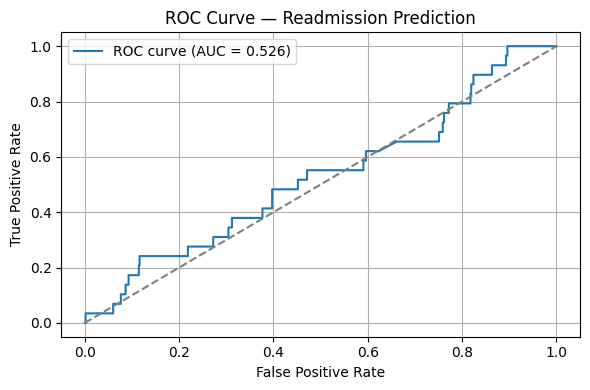

In [ ]:
# from sklearn.metrics import roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# Compute predicted probs for validation set
model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        probs, _ = model(x)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.numpy())

auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Readmission Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_auc(model, val_loader, device, return_auc=False):
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            logits, _ = model(x)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.numpy())

    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve — Readmission Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if return_auc:
        return auc


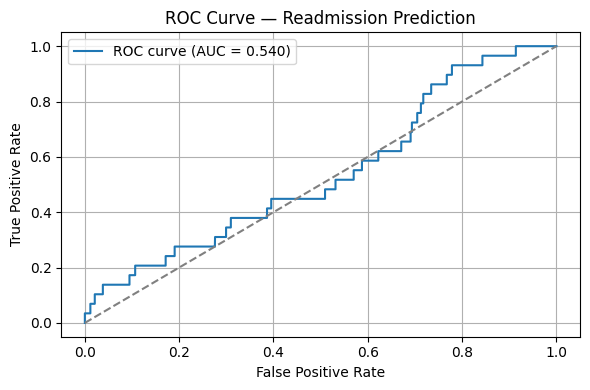

In [ ]:
plot_roc_auc(model, val_loader)

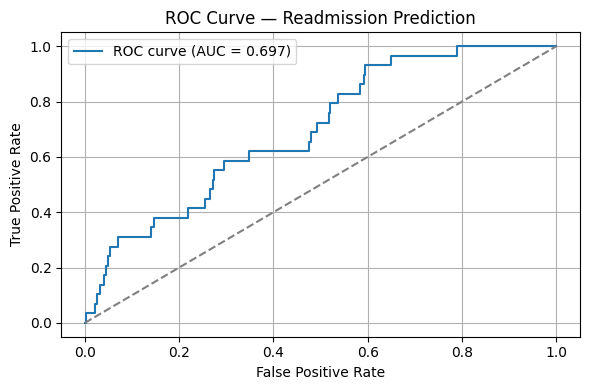

In [ ]:
plot_roc_auc(model_2, val_loader)

## Visualize Hidden States (h_T) with PCA / t-SNE

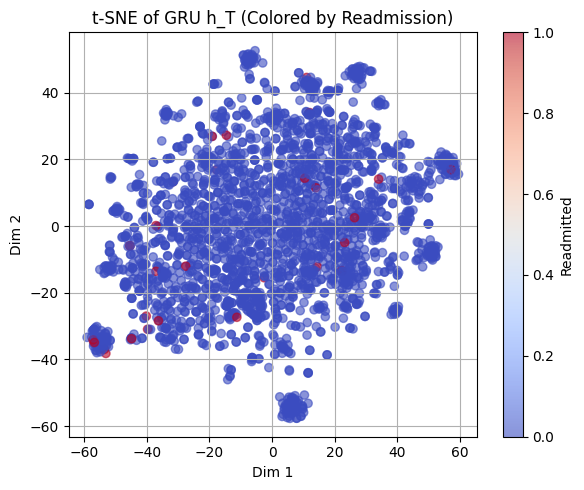

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Load embeddings from disk (or use ht_matrix)
ht = np.load("/content/drive/MyDrive/Spring2025/IEOR242B/Project/val_hidden.npy")
labels = np.load("/content/drive/MyDrive/Spring2025/IEOR242B/Project/val_labels.npy")

# First reduce with PCA to denoise, then t-SNE
pca = PCA(n_components=50).fit_transform(ht)
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title('t-SNE of GRU h_T (Colored by Readmission)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.colorbar(label='Readmitted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def visualize_ht_tsne(model, val_loader, device, save=False, path_prefix=base_dir):
    model.eval()
    all_ht = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            _, h_t = model(x)
            all_ht.append(h_t.cpu())
            all_labels.extend(y.numpy())

    ht_matrix = torch.cat(all_ht).numpy()
    labels = np.array(all_labels)

    # Optional: save for reuse
    if save:
        np.save(f"{path_prefix}val_hidden.npy", ht_matrix)
        np.save(f"{path_prefix}val_labels.npy", labels)
        print(f"Saved embeddings and labels to {path_prefix}*.npy")

    # Dim reduction: PCA → t-SNE
    pca = PCA(n_components=50).fit_transform(ht_matrix)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.title('t-SNE of GRU h_T (Colored by Readmission)')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.colorbar(label='Readmitted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 1 | Train Loss: 30.15 | Val Acc: 0.9888
Epoch 2 | Train Loss: 21.10 | Val Acc: 0.9884


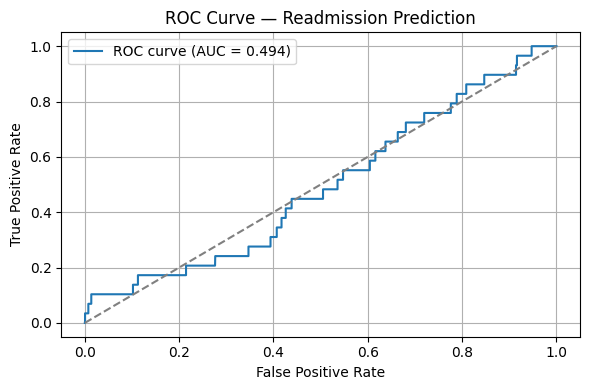

Saved embeddings and labels to /content/drive/MyDrive/Spring2025/IEOR242B/Project/*.npy


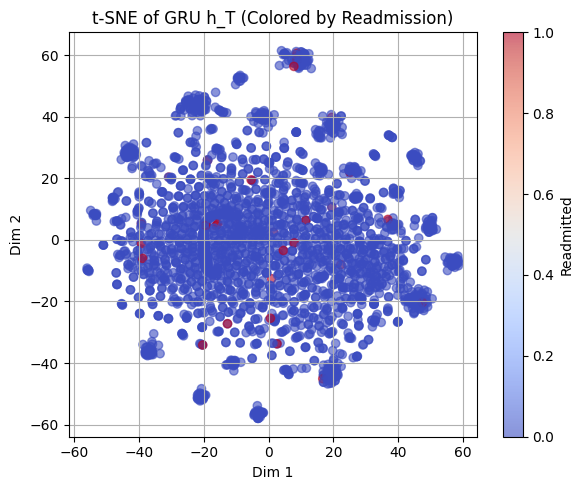

In [ ]:
# Model setup
model = ReadmitPredictor(vocab_size, embed_dim=256, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train model
trained_model = train_model(model, train_loader, val_loader, optimizer, loss_fn, device)

# Plot AUC
plot_roc_auc(trained_model, val_loader, device)

# Visualize latent space
visualize_ht_tsne(trained_model, val_loader, device, save=False, path_prefix="/content/drive/MyDrive/Spring2025/IEOR242B/Project/")


## Model Saving

In [89]:
def save_model(model, vocab, path_prefix):
    import torch
    model_path = f"{path_prefix}_text_model.pt"
    vocab_path = f"{path_prefix}_text_vocab.pkl"

    # Save weights
    torch.save(model.state_dict(), model_path)

    # Save vocab (optional but useful)
    import pickle
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)

    print(f"Saved model to {model_path}")
    print(f"Saved vocab to {vocab_path}")


## Explorations

### Use Pos_weight

Epoch 1 | Train Loss: 455.45 | Val Acc: 0.0112
Epoch 2 | Train Loss: 427.48 | Val Acc: 0.0112


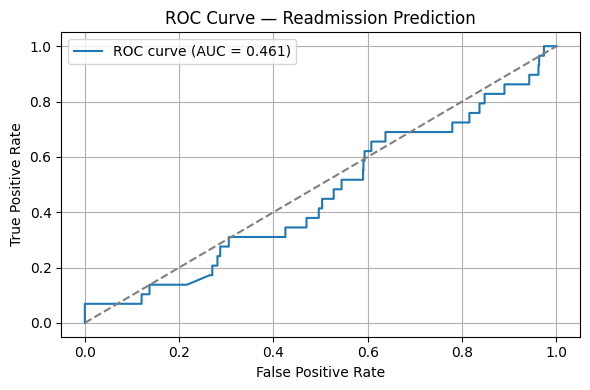

Saved model to /content/drive/MyDrive/Spring2025/IEOR242B/Project/readmit_model.pt
Saved vocab to /content/drive/MyDrive/Spring2025/IEOR242B/Project/readmit_vocab.pkl


In [ ]:
# Prepare model and optimizer
model = ReadmitPredictor(vocab_size, embed_dim=256, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Compute pos_weight
pos = df['readmitted'].sum()
neg = len(df) - pos
pos_weight = torch.tensor([neg / pos], dtype=torch.float).to(device)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Train
model = train_model(model, train_loader, val_loader, optimizer, loss_fn, device)

# Evaluate
plot_roc_auc(model, val_loader, device)

# Save model
save_model(model, vocab, path_prefix=f"{base_dir}savings/readmit")


### Pos_weight Clip

Epoch 1 | Train Loss: 223.11 | Val Acc: 0.9881
Epoch 2 | Train Loss: 132.82 | Val Acc: 0.9361


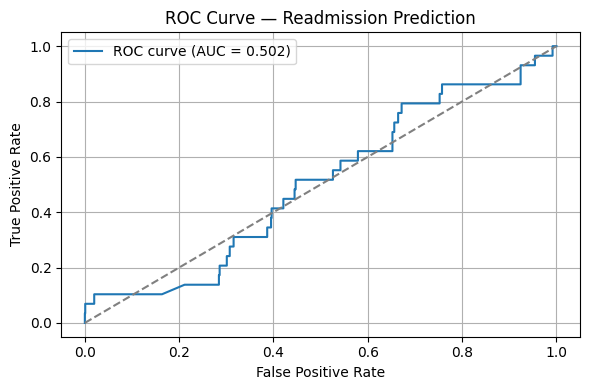

In [19]:
# Prepare model and optimizer
model = ReadmitPredictor(vocab_size, embed_dim=256, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Compute pos_weight
pos = df['readmitted'].sum()
neg = len(df) - pos

adjusted_weight_clip = min(neg / pos, 20.0)
loss_fn_clip = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([adjusted_weight_clip]).to(device))

model_clip = train_model(model, train_loader, val_loader, optimizer, loss_fn_clip, device)
auc_clip = plot_roc_auc(model_clip, val_loader, device, return_auc=True)


### Update Downsampling

In [185]:
# Load full notes_readmit.csv
df = pd.read_csv("/content/drive/MyDrive/Spring2025/IEOR242B/Project/notes_readmit.csv")

# Compute pos_weight on full label dist
pos_weight = compute_pos_weight(df['readmitted'].tolist(), max_clip=20.0).to(device)

# Downsample to balanced dataset
df_bal = downsample_negatives(df)

# Proceed with balanced df
train_texts_bal, val_texts_bal, train_labels_bal, val_labels_bal = train_test_split(
    df_bal['text_note'].tolist(), df_bal['readmitted'].tolist(), test_size=0.2, random_state=42
)

# Create vocab, dataset, dataloaders (as before)

# Simple whitespace tokenizer
def tokenize(text):
    return text.lower().split()

# Build vocab (keep tokens with frequency ≥2)
counter_bal = Counter()
for text in df_bal['text_note']:
    counter_bal.update(tokenize(text))

special_tokens = ['<PAD>', '<UNK>']
vocab_bal = {tok: idx for idx, tok in enumerate(special_tokens)}
for word, freq in counter.items():
    if freq >= 2:
        vocab_bal[word] = len(vocab_bal)

vocab_bal_size = len(vocab_bal)
print(f"Vocab size: {vocab_bal_size}")

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

MAX_LEN = 256  # truncate long notes
PAD_IDX_bal = vocab_bal['<PAD>']
UNK_IDX_bal = vocab_bal['<UNK>']

class NotesDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx])
        idxs = [self.vocab.get(tok, UNK_IDX) for tok in tokens[:self.max_len]]
        return torch.tensor(idxs, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

    def __len__(self):
        return len(self.texts)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    padded = pad_sequence(inputs, batch_first=True, padding_value=PAD_IDX)
    return padded, torch.stack(labels)

# Create loaders
train_bal_ds = NotesDataset(train_texts_bal, train_labels_bal, vocab_bal)
val_bal_ds   = NotesDataset(val_texts_bal, val_labels_bal, vocab_bal)

train_bal_loader = DataLoader(train_bal_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_bal_loader   = DataLoader(val_bal_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_bal_loader)}, Val batches: {len(val_bal_loader)}")
# Train batches: 325, Val batches: 82 without downsample

Vocab size: 175107
Train batches: 9, Val batches: 3


Epoch 1 | Train Loss: 6.21 | Val Acc: 0.4242
Epoch 2 | Train Loss: 5.39 | Val Acc: 0.4242


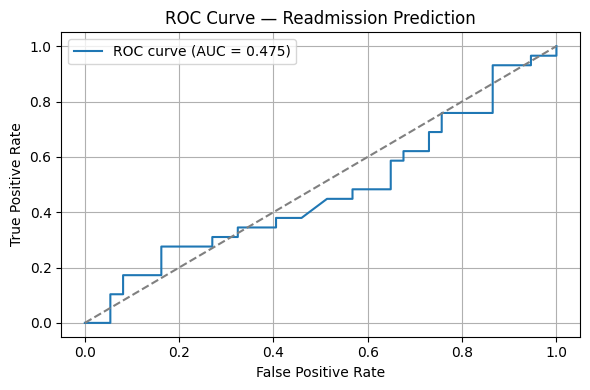

In [186]:
# Prepare model and optimizer
model_bal = ReadmitPredictor(vocab_bal_size, embed_dim=256, hidden_dim=128)
optimizer_bal = torch.optim.Adam(model_bal.parameters(), lr=1e-3)

# Compute pos_weight
pos_bal = df_bal['readmitted'].sum()
neg_bal = len(df_bal) - pos_bal

adjusted_weight_bal = min(neg_bal / pos_bal, 20.0)
loss_fn_bal = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([adjusted_weight_bal]).to(device))

trained_model_bal = train_model(model_bal, train_bal_loader, val_bal_loader, optimizer_bal, loss_fn_bal, device, epochs=3)
auc_bal = plot_roc_auc(trained_model_bal, val_bal_loader, device, return_auc=True)

In [92]:
save_model(model_bal, vocab_bal, path_prefix=f"{base_dir}/readmit")

Saved model to /content/drive/MyDrive/Spring2025/IEOR242B/Project/readmit_text_model.pt
Saved vocab to /content/drive/MyDrive/Spring2025/IEOR242B/Project/readmit_text_vocab.pkl


# Time-Series FFNN Baseline
## Data Extraction

In [161]:
import pandas as pd

# Paths
base = "/content/drive/MyDrive/Spring2025/IEOR242B/Project/"
lab_path = base + "LABEVENTS.csv"
input_mv_path = base + "INPUTEVENTS_MV.csv"
input_cv_path = base + "INPUTEVENTS_CV.csv"
output_path = base + "OUTPUTEVENTS.csv"
proc_path = base + "PROCEDUREEVENTS_MV.csv"
label_path = base + "notes_readmit.csv"

# Load core files
labs = pd.read_csv(lab_path, usecols=['SUBJECT_ID','HADM_ID','ITEMID','VALUENUM'])
inputs_mv = pd.read_csv(input_mv_path, usecols=['SUBJECT_ID','HADM_ID','ITEMID','AMOUNT'])
inputs_cv = pd.read_csv(input_cv_path, usecols=['SUBJECT_ID','HADM_ID','ITEMID','AMOUNT'])
outputs = pd.read_csv(output_path, usecols=['SUBJECT_ID','HADM_ID','ITEMID','VALUE'])
procedures = pd.read_csv(proc_path, usecols=['SUBJECT_ID','HADM_ID','ITEMID','VALUE'])
labels = pd.read_csv(label_path, usecols=['patient_id','readmitted'])  # from text baseline

# Preview
print(f"Labs: {len(labs)} | Inputs: {len(inputs_mv)+len(inputs_cv)} | Outputs: {len(outputs)} | Procs: {len(procedures)}")


Labs: 6089629 | Inputs: 8603563 | Outputs: 1028495 | Procs: 148178


## Data Preprocessing

In [162]:
# Step 2: group and aggregate each table
def aggregate_table(df, value_col, prefix):
    agg = df.groupby('HADM_ID')[value_col].agg(['mean', 'std', 'min', 'max', 'count'])
    agg.columns = [f"{prefix}_{col}" for col in agg.columns]
    return agg

lab_feats = aggregate_table(labs, 'VALUENUM', 'lab')
input_feats = aggregate_table(pd.concat([inputs_mv, inputs_cv]), 'AMOUNT', 'input')
output_feats = aggregate_table(outputs, 'VALUE', 'output')
proc_feats = aggregate_table(procedures, 'VALUE', 'proc')


## Merge Features + Labels

In [163]:
# Merge all features on HADM_ID
features = lab_feats.join([input_feats, output_feats, proc_feats], how='outer')
features = features.reset_index()  # HADM_ID becomes column

# Merge with labels using SUBJECT_ID = patient_id
admissions = pd.read_csv(base + "ADMISSIONS.csv", usecols=["SUBJECT_ID","HADM_ID"])
features = pd.merge(features, admissions, on="HADM_ID", how="left")
features = pd.merge(features, labels, left_on="SUBJECT_ID", right_on="patient_id", how="inner")

# Final cleanup
features = features.drop(columns=["SUBJECT_ID","patient_id"]).dropna()
print("Final feature matrix:", features.shape)


Final feature matrix: (34, 22)


## Build FFNN Dataset

In [164]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(features.drop(columns=['readmitted']).values)
y = features['readmitted'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


## Model Construction

In [165]:
import torch.nn as nn

class TabularFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)  # logits


## Update Method

In [166]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Model init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=2):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            if isinstance(logits, tuple):  # handle GRU (logits, h_t)
                logits = logits[0]
            loss = loss_fn(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        val_acc = evaluate_accuracy(model, val_loader, device)
        print(f"Epoch {epoch+1} | Train Loss: {total_loss:.2f} | Val Acc: {val_acc:.4f}")
    return model

def evaluate_accuracy(model, loader, device):
    from sklearn.metrics import accuracy_score
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            if isinstance(logits, tuple):
                logits = logits[0]
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return accuracy_score(all_labels, all_preds)


In [167]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch


def plot_roc_auc(model, val_loader, device, return_auc=False):
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            logits = model(x)
            if isinstance(logits, tuple):
                logits = logits[0]
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.numpy())

    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve — Readmission Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if return_auc:
        return auc

def save_tabular_embeddings_and_visualize(model, val_loader, device, save=True, path_prefix=""):
    model.eval()
    all_embs = []
    all_labels = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            # Extract penultimate layer embedding (assumes model.net: Linear->ReLU->Linear)
            hidden = model.net[0](x)  # first Linear layer output
            hidden = model.net[1](hidden)  # ReLU
            all_embs.append(hidden.cpu())
            all_labels.extend(y.numpy())

    emb_matrix = torch.cat(all_embs).numpy()
    labels = np.array(all_labels)

    if save:
        np.save(f"{path_prefix}val_tabular_emb.npy", emb_matrix)
        np.save(f"{path_prefix}val_labels.npy", labels)
        print(f"Saved embeddings and labels to {path_prefix}val_tabular_emb.npy and {path_prefix}val_labels.npy")

        # min(n_samples, n_features)

    # Dimensionality reduction: PCA then t-SNE
    # pca_result = PCA(n_components=7).fit_transform(emb_matrix)
    # tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca_result)

    # plt.figure(figsize=(7,6))
    # scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    # plt.colorbar(scatter, label='Readmitted')
    # plt.title("t-SNE Visualization of Tabular FFNN Embeddings")
    # plt.xlabel("t-SNE Dim 1")
    # plt.ylabel("t-SNE Dim 2")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

def save_model(model, vocab, path_prefix):
    import torch
    import pickle

    model_path = f"{path_prefix}_ffnn_model.pt"
    vocab_path = f"{path_prefix}_vocab.pkl"

    torch.save(model.state_dict(), model_path)
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)

    print(f"Saved FFNN model weights to {model_path}")
    print(f"Saved vocab to {vocab_path}")


## Training Appraoch

Epoch 1 | Train Loss: 1.29 | Val Acc: 0.5714
Epoch 2 | Train Loss: 1.27 | Val Acc: 0.5714


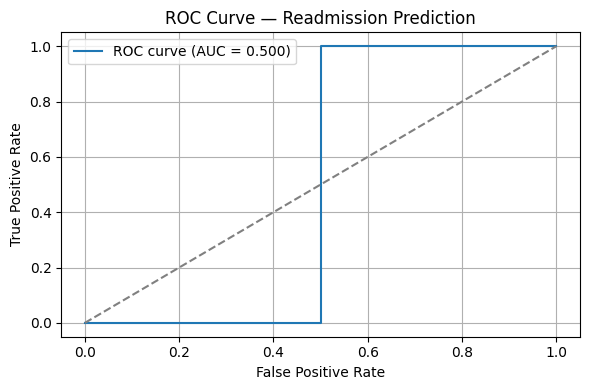

In [107]:
input_dim = X_train.shape[1]
model = TabularFFNN(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Reuse pos_weight helper
pos_weight = compute_pos_weight(y_train.tolist(), max_clip=20.0).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=2)
plot_roc_auc(model, val_loader, device)


Epoch 1 | Train Loss: 1.31 | Val Acc: 0.1429
Epoch 2 | Train Loss: 1.30 | Val Acc: 0.1429
Epoch 3 | Train Loss: 1.30 | Val Acc: 0.1429
Epoch 4 | Train Loss: 1.30 | Val Acc: 0.1429
Epoch 5 | Train Loss: 1.30 | Val Acc: 0.1429
Epoch 6 | Train Loss: 1.30 | Val Acc: 0.1429
Epoch 7 | Train Loss: 1.30 | Val Acc: 0.1429
Epoch 8 | Train Loss: 1.29 | Val Acc: 0.1429
Epoch 9 | Train Loss: 1.29 | Val Acc: 0.1429
Epoch 10 | Train Loss: 1.29 | Val Acc: 0.1429
Epoch 11 | Train Loss: 1.29 | Val Acc: 0.1429
Epoch 12 | Train Loss: 1.29 | Val Acc: 0.1429
Epoch 13 | Train Loss: 1.29 | Val Acc: 0.1429
Epoch 14 | Train Loss: 1.29 | Val Acc: 0.1429
Epoch 15 | Train Loss: 1.28 | Val Acc: 0.1429
Epoch 16 | Train Loss: 1.28 | Val Acc: 0.1429
Epoch 17 | Train Loss: 1.28 | Val Acc: 0.1429
Epoch 18 | Train Loss: 1.28 | Val Acc: 0.1429
Epoch 19 | Train Loss: 1.28 | Val Acc: 0.1429
Epoch 20 | Train Loss: 1.28 | Val Acc: 0.1429
Epoch 21 | Train Loss: 1.27 | Val Acc: 0.1429
Epoch 22 | Train Loss: 1.27 | Val Acc: 0.14

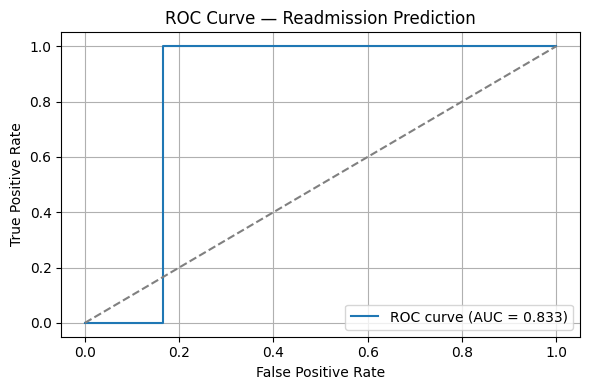

Saved embeddings and labels to /content/drive/MyDrive/Spring2025/IEOR242B/Project/val_tabular_emb.npy and /content/drive/MyDrive/Spring2025/IEOR242B/Project/val_labels.npy
Saved FFNN model weights to /content/drive/MyDrive/Spring2025/IEOR242B/Project/readmit_tabular_ffnn_model.pt
Saved vocab to /content/drive/MyDrive/Spring2025/IEOR242B/Project/readmit_tabular_vocab.pkl


In [168]:
# (1) Define and train tabular FFNN
input_dim = X_train.shape[1]
model = TabularFFNN(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Reuse pos_weight helper
pos_weight = compute_pos_weight(y_train.tolist(), max_clip=20.0).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=200)

# (2) Plot ROC-AUC
plot_roc_auc(model, val_loader, device)

# (3) Save tabular embeddings + t-SNE visualization
save_tabular_embeddings_and_visualize(
    model=model,
    val_loader=val_loader,
    device=device,
    save=True,
    path_prefix="/content/drive/MyDrive/Spring2025/IEOR242B/Project/"
)

# (4) Save model + vocab
save_model(
    model=model,
    vocab={},  # if you have a tabular feature index map, pass it here
    path_prefix="/content/drive/MyDrive/Spring2025/IEOR242B/Project/readmit_tabular"
)


# Multimodal Final

### Load pretrained embeddings and labels for train/val sets

In [125]:
import torch, pickle, numpy as np, pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Paths
base = "/content/drive/MyDrive/Spring2025/IEOR242B/Project/"
text_model_path    = base + "readmit_text_model.pt"
text_vocab_path    = base + "readmit_text_vocab.pkl"
tab_model_path     = base + "readmit_tabular_ffnn_model.pt"
tab_vocab_path     = base + "readmit_tabular_vocab.pkl"   # if you saved it
notes_path         = base + "notes_readmit.csv"
features_path      = base + "aggregated_tabular_features.csv"        # wherever you saved your aggregated features

import pandas as pd
from sklearn.preprocessing import StandardScaler

base = "/content/drive/MyDrive/Spring2025/IEOR242B/Project/"

# Load raw CSVs (use cols to reduce memory)
labs = pd.read_csv(base + "LABEVENTS.csv", usecols=['HADM_ID','VALUENUM'])
inputs_mv = pd.read_csv(base + "INPUTEVENTS_MV.csv", usecols=['HADM_ID','AMOUNT'])
inputs_cv = pd.read_csv(base + "INPUTEVENTS_CV.csv", usecols=['HADM_ID','AMOUNT'])
outputs = pd.read_csv(base + "OUTPUTEVENTS.csv", usecols=['HADM_ID','VALUE'])
procedures = pd.read_csv(base + "PROCEDUREEVENTS_MV.csv", usecols=['HADM_ID','VALUE'])

def aggregate(df, col, prefix):
    agg = df.groupby('HADM_ID')[col].agg(['mean', 'std', 'min', 'max', 'count'])
    agg.columns = [f"{prefix}_{c}" for c in agg.columns]
    return agg

lab_feats = aggregate(labs, 'VALUENUM', 'lab')
input_feats = aggregate(pd.concat([inputs_mv, inputs_cv]), 'AMOUNT', 'input')
output_feats = aggregate(outputs, 'VALUE', 'output')
proc_feats = aggregate(procedures, 'VALUE', 'proc')

# Merge all aggregated features on HADM_ID
features = lab_feats.join([input_feats, output_feats, proc_feats], how='outer').reset_index()

# Load admission labels (from notes_readmit.csv join or separately)
notes_df = pd.read_csv(base + "notes_readmit.csv")
admits = pd.read_csv(base + "ADMISSIONS.csv", usecols=['SUBJECT_ID','HADM_ID'])
labels_df = pd.merge(admits, notes_df[['patient_id','readmitted']], left_on='SUBJECT_ID', right_on='patient_id', how='inner')

# Merge labels into features by HADM_ID
full_df = pd.merge(features, labels_df[['HADM_ID','readmitted']], on='HADM_ID', how='inner')

# Drop rows with missing data (if any)
full_df = full_df.dropna().reset_index(drop=True)

# Normalize features
scaler = StandardScaler()
X = full_df.drop(columns=['HADM_ID','readmitted'])
X_scaled = scaler.fit_transform(X)

# Save for later use
full_df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
full_df_scaled['readmitted'] = full_df['readmitted']
full_df_scaled['HADM_ID'] = full_df['HADM_ID']
full_df_scaled.to_csv(base + "aggregated_tabular_features.csv", index=False)

print("Aggregated tabular features saved to aggregated_tabular_features.csv")
print(f"Shape: {full_df_scaled.shape}")


Aggregated tabular features saved to aggregated_tabular_features.csv
Shape: (34, 22)


#### Extraction

In [136]:
import pandas as pd

base = "/content/drive/MyDrive/Spring2025/IEOR242B/Project/"

# Load raw text notes + labels
df_notes = pd.read_csv(base + "notes_readmit.csv")  # patient_id, text_note, readmitted

# Load tabular features and join with notes by HADM_ID
df_admits = pd.read_csv(base + "ADMISSIONS.csv", usecols=["SUBJECT_ID", "HADM_ID"])
df_features = pd.read_csv(base + "aggregated_tabular_features.csv")  # created earlier

# Merge all on HADM_ID
df_all = pd.merge(df_admits, df_notes, left_on="SUBJECT_ID", right_on="patient_id", how="inner")
df_all = pd.merge(df_all, df_features, on="HADM_ID", how="inner")

# Final clean table
df_all = df_all.dropna().reset_index(drop=True)
print("Final multimodal fusion table shape:", df_all.shape)


Final multimodal fusion table shape: (84, 26)


In [140]:
import torch, pickle
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Load vocab and model
with open(base + "readmit_text_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

PAD_IDX = vocab['<PAD>']
UNK_IDX = vocab['<UNK>']

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=256):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        toks = self.texts[idx].lower().split()[:self.max_len]
        ids = [self.vocab.get(tok, UNK_IDX) for tok in toks]
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

def collate_text(batch):
    sequences, labels = zip(*batch)
    return pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX), torch.stack(labels)

# Dataset
text_ds = TextDataset(df_all['text_note'].tolist(), df_all['readmitted_y'].tolist(), vocab)
text_loader = DataLoader(text_ds, batch_size=32, collate_fn=collate_text)

# Load trained model
class ReadmitPredictor(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=128):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = torch.nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1)
    def forward(self, x):
        emb = self.embedding(x)
        _, h_n = self.gru(emb)
        return self.fc(h_n.squeeze(0)).squeeze(1), h_n.squeeze(0)

text_model = ReadmitPredictor(len(vocab)).to("cpu")
text_model.load_state_dict(torch.load(base + "readmit_text_model.pt", map_location="cpu"))
text_model.eval()

# Extract final h_T
all_text_ht = []
with torch.no_grad():
    for x, y in text_loader:
        _, h = text_model(x)
        all_text_ht.append(h)

text_emb = torch.cat(all_text_ht).numpy()
print("Text embedding shape:", text_emb.shape)


Text embedding shape: (84, 128)


In [143]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X_tab = df_all.drop(columns=["SUBJECT_ID", "HADM_ID", "patient_id", "text_note", "readmitted_y"])
y = df_all['readmitted_y'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tab)

class TabularFFNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        h = self.net[0](x)
        h = self.net[1](h)
        return self.net[2](h).squeeze(1), h

tab_model = TabularFFNN(X_scaled.shape[1]).to("cpu")
tab_model.load_state_dict(torch.load(base + "readmit_tabular_ffnn_model.pt", map_location="cpu"))
tab_model.eval()

# Extract embeddings
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
with torch.no_grad():
    _, tab_emb = tab_model(X_tensor)

tab_emb = tab_emb.numpy()
print("Tabular embedding shape:", tab_emb.shape)


Tabular embedding shape: (84, 64)


In [144]:
np.save(base + "all_text_emb.npy", text_emb)
np.save(base + "all_tabular_emb.npy", tab_emb)
np.save(base + "all_labels.npy", y)
print("Saved all_text_emb.npy, all_tabular_emb.npy, all_labels.npy")


Saved all_text_emb.npy, all_tabular_emb.npy, all_labels.npy


#### continue

In [145]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# 1) Load the full embeddings + labels (not just the val subset)
text_emb = torch.from_numpy(np.load('/content/drive/MyDrive/Spring2025/IEOR242B/Project/all_text_emb.npy')).float()
tab_emb  = torch.from_numpy(np.load('/content/drive/MyDrive/Spring2025/IEOR242B/Project/all_tabular_emb.npy')).float()
labels   = torch.from_numpy(np.load('/content/drive/MyDrive/Spring2025/IEOR242B/Project/all_labels.npy')).float()

# 2) Stratified train/val split on the full dataset
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    random_state=42,
    stratify=labels.numpy()
)

# 3) Quick sanity check
print("Train positives:", int(labels[train_idx].sum().item()), "/", len(train_idx))
print("Val   positives:",  int(labels[val_idx].sum().item()),    "/", len(val_idx))

# 4) Build Dataset & DataLoader
class FusionDataset(Dataset):
    def __init__(self, text_emb, tab_emb, labels, idxs):
        self.text = text_emb[idxs]
        self.tab  = tab_emb[idxs]
        self.lab  = labels[idxs]
    def __len__(self): return len(self.lab)
    def __getitem__(self, i):
        return self.text[i], self.tab[i], self.lab[i]

train_ds = FusionDataset(text_emb, tab_emb, labels, train_idx)
val_ds   = FusionDataset(text_emb, tab_emb, labels, val_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train positives: 11 / 67
Val   positives: 3 / 17
Train batches: 3, Val batches: 1


In [146]:
print("Train label distribution:", labels[train_idx].sum().item(), "/", len(train_idx))
print("Val label distribution:", labels[val_idx].sum().item(), "/", len(val_idx))


Train label distribution: 11.0 / 67
Val label distribution: 3.0 / 17


### Define Fusion Module with Weighted Concatenation + Norm

In [131]:
import torch.nn as nn
import torch.nn.functional as F

class WeightedFusionHead(nn.Module):
    def __init__(self, text_dim, tab_dim, hidden_dim=64):
        super().__init__()
        self.text_norm = nn.LayerNorm(text_dim)
        self.tab_norm = nn.LayerNorm(tab_dim)

        # Learnable scalar weights (initialized 1.0)
        self.text_weight = nn.Parameter(torch.ones(1))
        self.tab_weight = nn.Parameter(torch.ones(1))

        # Fusion MLP head
        self.fusion_mlp = nn.Sequential(
            nn.Linear(text_dim + tab_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, text_emb, tab_emb):
        text_normed = self.text_norm(text_emb)
        tab_normed = self.tab_norm(tab_emb)

        # Weighted concatenation
        fused = torch.cat([self.text_weight * text_normed, self.tab_weight * tab_normed], dim=1)

        logits = self.fusion_mlp(fused).squeeze(1)  # logits for BCEWithLogitsLoss
        return logits


### Freeze Pretrained encoders and instantiate fusion head

In [115]:
tabular_emb = np.load("/content/drive/MyDrive/Spring2025/IEOR242B/Project/val_tabular_emb.npy")
print("Loaded tabular embedding shape:", tabular_emb.shape[1])


Loaded tabular embedding shape: 64


### Sanity Check

In [116]:
# Sanity Check
print(sum(p.numel() for p in ffnn_model.parameters() if p.requires_grad))  # should be small (a few thousand)


4225


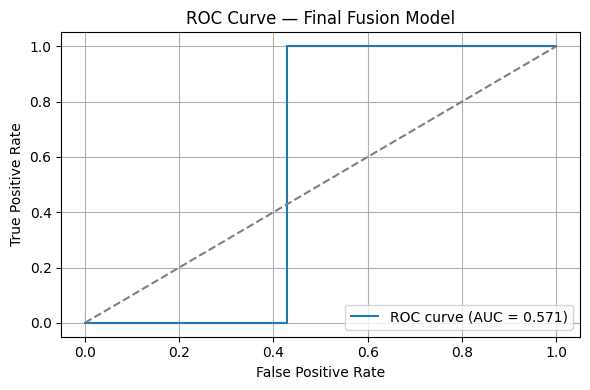

AUC for the Final Fusion Model on the validation set: 0.5714


In [160]:
# prompt: print auc for final_fusion_model

# Assuming 'trained_fusion' is the final trained fusion model
# and 'val_loader' is the validation DataLoader
# and 'device' is the device the model is on ('cuda' or 'cpu')

def plot_roc_auc_fusion(model, val_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for text_emb, tab_emb, y in val_loader:
            text_emb, tab_emb, y = text_emb.to(device), tab_emb.to(device), y.to(device)
            logits = model(text_emb, tab_emb)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve — Final Fusion Model')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return auc

# Evaluate and plot ROC for the final fusion model
auc_final_fusion = plot_roc_auc_fusion(trained_fusion, val_loader, device)
print(f"AUC for the Final Fusion Model on the validation set: {auc_final_fusion:.4f}")


In [157]:
def train_fusion(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=200):
    from sklearn.metrics import accuracy_score, roc_auc_score

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for text_emb, tab_emb, y in train_loader:
            text_emb, tab_emb, y = text_emb.to(device), tab_emb.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(text_emb, tab_emb)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        val_acc, val_auc = evaluate_fusion(model, val_loader, device)
        print(f"Epoch {epoch+1} | Train Loss: {total_loss:.3f} | Val Acc: {val_acc:.4f}")

    return model

def evaluate_fusion(model, val_loader, device):
    from sklearn.metrics import accuracy_score, roc_auc_score
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for text_emb, tab_emb, y in val_loader:
            text_emb, tab_emb, y = text_emb.to(device), tab_emb.to(device), y.to(device)
            logits = model(text_emb, tab_emb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    model.train()
    return acc, auc

text_dim = text_ht.shape[1]
tab_dim = tabular_emb.shape[1]

fusion_model = WeightedFusionHead(text_dim, tab_dim, hidden_dim=64).to(device)

optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss()

# Start training
trained_fusion = train_fusion(fusion_model, train_loader, val_loader, optimizer, loss_fn, device)


Epoch 1 | Train Loss: 1.862 | Val Acc: 0.7647
Epoch 2 | Train Loss: 1.810 | Val Acc: 0.7647
Epoch 3 | Train Loss: 1.837 | Val Acc: 0.8235
Epoch 4 | Train Loss: 1.759 | Val Acc: 0.8235
Epoch 5 | Train Loss: 1.702 | Val Acc: 0.8235
Epoch 6 | Train Loss: 1.693 | Val Acc: 0.8235
Epoch 7 | Train Loss: 1.855 | Val Acc: 0.8235
Epoch 8 | Train Loss: 1.689 | Val Acc: 0.8235
Epoch 9 | Train Loss: 1.721 | Val Acc: 0.8235
Epoch 10 | Train Loss: 1.833 | Val Acc: 0.8235
Epoch 11 | Train Loss: 1.747 | Val Acc: 0.8235
Epoch 12 | Train Loss: 1.674 | Val Acc: 0.8235
Epoch 13 | Train Loss: 1.814 | Val Acc: 0.8235
Epoch 14 | Train Loss: 1.639 | Val Acc: 0.8235
Epoch 15 | Train Loss: 1.533 | Val Acc: 0.8235
Epoch 16 | Train Loss: 1.478 | Val Acc: 0.8235
Epoch 17 | Train Loss: 1.559 | Val Acc: 0.8235
Epoch 18 | Train Loss: 1.424 | Val Acc: 0.8235
Epoch 19 | Train Loss: 1.459 | Val Acc: 0.8235
Epoch 20 | Train Loss: 1.349 | Val Acc: 0.8235
Epoch 21 | Train Loss: 1.354 | Val Acc: 0.8235
Epoch 22 | Train Loss: